# E2 — Exercises on Physical Chemistry

This notebook contains interactive exercises related to the L2 session on physical chemistry. The theory related to these exercises is covered in the lecture notes, which you can find here:
* [L2 — Overview of Physical Chemistry and the Cell Membrane](L2%20—%20Overview%20of%20Physical%20Chemistry.ipynb)

The notebook contains the following example and exercises (you can click the links)
* [Example: Modeling a reaction with the Law of Mass Action](#mass_action)
* [Exercise 1: Modeling a Two-way Reaction to Understand Equilibrium](#equilibrium)
* [Exercise 2: Modeling Michelis-Menten Kinetics](#kinetics)

<a id="mass_action"></a>
## Example 1: Modeling a unidirectional chemical reaction

In this example we are looking at the unidirectional binding reaction

\begin{equation}
\mathrm{Mb} + \mathrm{O_2} \overset{k}{\longrightarrow} \mathrm{MbO_2}.
\end{equation}

As explained in the lecture notes, this leads to the following set of three ordinary differential equations (ODEs)

\begin{equation}
\frac{\mathrm{d[MbO_2]}}{\mathrm{d}t} = k\mathrm{[Mb][O_2]}, \qquad \frac{\mathrm{d [Mb]}}{\mathrm{d}t} = -k\mathrm{[Mb]}\mathrm{[O_2]}, \qquad \frac{\mathrm{d [O_2]}}{\mathrm{d}t} = -k\mathrm{[Mb]}\mathrm{[O_2]}.
\end{equation}

We will now solve these equations numerically. Shortly you will repeat this exercise for the *reversible* reaction, so this serves as an example that you can copy.

#### Initial Value Problems

Solving these ODEs is an example of what we call an *initial value problem*. And we will use the function [`scipy.integrate.solve_ivp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) to solve this problem numerically. It's not too technical to implement our own solver, but that is not really the main focus of this session, and so we rely on this existing solver.

However, if you have never solved ODEs numerically before, it can be helpful to learn a bit more about the process in detail. In that case we recommend the (short) open-access book [*Finite Difference Computing with Exponential Decay Models*](http://www.springer.com/us/book/9783319294384) by Professor Hans Petter Langtangen. It is an easy to understand, but quite thorough introduction to these kinds of numerical solvers. It mainly focuses on exponential decay, which is *very* relevant to our course, and even has a sub-chapter on chemical reactions.

#### Explanation of `solve_ivp`

For the function `solve_ivp` to be able to solve our problem, we need to supply a set of inputs:
1. The ODE system itself, i.e., the equations
2. The *initial values* of each state
3. Which time interval to solve for

To specify the ODE equations themselves, we implement them as a Python function. More specifically, we write out the derivatives of the system as a vector equation on the form

$$\frac{{\rm d}\vec{y}}{{\rm d}t} = \vec{f}(t, {\vec y}).$$

Here $y$ is a vector that contains all the *state variables* of your system. The states are the quantities which you are modeling, in our case, the three concentrations. The function $f$ thus represents what we call the *right hand side* of the ODEs, and so often one uses the short-hand RHS as well. Note that the RHS function also takes in the time $t$, this can be a bit confusing - so we will explain this a bit more in detail shortly.

In our example, it would for example be

$$\vec{y} = (\mathrm{[MbO_2]}, \mathrm{[Mb]}, \mathrm{[O_2]}).$$

In addition, the function $f$ takes in the time $t$.

The function $\vec{f}$ should now represent the right-hand side of the ODE-system, i.e., the derivative of each state in the system. In our case, this would be

$$\vec{f}(t, \vec{y}) = \bigg(\frac{\mathrm{d [Mb O_2]}}{\mathrm{d}t}, \frac{\mathrm{d [Mb]}}{\mathrm{d}t},  \frac{\mathrm{d [O_2]}}{\mathrm{d}t}\bigg).$$

Note that the order you list the states is not important, but it **is** important that the order you place them in is the same for the vector $y$ and the RHS - i.e., be consistent with your ordering.

Let us implement this RHS function

#### Implementing the RHS

In [1]:
# Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
# Implement the right-hand-side of the system as a function
def rhs(t, y, k):
    # Unpack the state vector to make it easier to write neat code
    MbO2, Mb, O2 = y

    # Formulate derivatives
    dMbO2_dt = k*Mb*O2
    dMb_dt = -k*Mb*O2
    dO2_dt = -k*Mb*O2
    
    # Return derivatives as a vector
    return (dMbO2_dt, dMb_dt, dO2_dt)

Note that the function *needs* to take in a time as its first argument at the state vector, $y$, as its second. This is the only way the `solve_ivp` function will work. You might find this confusing, as our ODEs don't actually depend on $t$ explicitly. However, a *general* ODE might, and `solve_ivp` is designed to work with a general system of ODEs, so this is the way it works.

Note that we can also add as many model parameters we want as additional arguments.

#### Calling `solve_ivp`

Next we need to define what time-interval to solve for. We can do this by creating a tuple of the start and finish time, for instance, if we want to solve for $t\in [0, 5]$, we can do

In [3]:
# Define what time-interval to solve for
time = (0, 3)

Next we define the initial conditions as a vector, typically called $\vec{y}_0$. The ordering of the states will be the same as we defined the RHS, i.e., (MbO$_2$, Mb, O$_2$).

In [4]:
# Define the initial condition
y0 = (0.0, 2.2, 5.4)

Next we should define any model parameters needed to actually compute the problem. In this case we only have the rate constant $k$, but let us do it in a manner where it can be easily increased to more parameters (some of the later models in this course will have dozens, if not hundreds, of adjustable parameters).

In [5]:
# Define any model parameters
k = 1.7
params = (k,)

Here `params` becomes a vector of model parameters. Note that the final comma is actually needed to turn it into a vector when we only have a single element in there.

Now we are ready to call `solve_ivp`. Here we go

In [6]:
# Call the ODE solver
solution = solve_ivp(rhs, time, y0, args=params)

Note that we send in the parameters as an optional keyword-argument called `args`. This looks a bit technical, but is again just because we want to show you how it can be done for larger systems. You can easily avoid the whole `params` and `args` parts of the code by simply defining the $k$ parameter inside the RHS function, or as a global parameter. That works just fine for smaller models, but can get a bit messy for larger ones.

The `solution` object which is returned from `solve_ivp` is a so-called "bunch" object in Python. This is a variable with plenty of properties we can read out. You can try simply `printing` it, but that isn't super useful. Let us instead read out the solutions and plot them.

In [7]:
# We can extract a time array and the solutions of the state vectors over time
t = solution.t
y = solution.y

print(f"The t variable is now a {t.shape} vector")
print(f"The y variable is now a {y.shape} vector")

The t variable is now a (20,) vector
The y variable is now a (3, 20) vector


The $t$-vector contains the time points at which the solution has been computed, and the $y$-vector contains the value of the each state variable for each time point. It is often useful to split the $y$-vector into vectors for each state, unless you love working with multi-dimensional numpy-arrays.

In [11]:
# Split up into individual states
MbO2, Mb, O2 = y

print(f"Each state variable (e.g., MbO2) is now shape {MbO2.shape}")

Each state variable (e.g., MbO2) is now shape (20,)


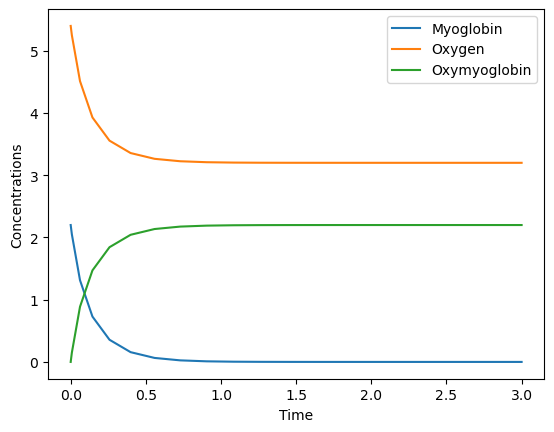

In [12]:
plt.plot(t, Mb, label='Myoglobin')
plt.plot(t, O2, label='Oxygen')
plt.plot(t, MbO2, label='Oxymyoglobin')

plt.xlabel('Time')
plt.ylabel('Concentrations')
plt.legend()
plt.show()

Note that we only specify for what time interval we want to solve the equations, and `solve_ivp` gets to decide what time points to actually use. It is an adaptive solver, meaning it can increase or decrease the actual time step as it sees fit. However, some care really needs to be taken here. Later in the course you will learn about ion channels and channel *gating*. Put simply, due to this gating, the ODE systems we set up will be *incredibly* stiff, meaning they can change in nature very rapidly. An adaptive solver is quite notorious at struggling with such equations, and so we should add an optional argument to force `solve_ivp` to be more careful. We can use the argument `max_step`, which sets the maximal allowable time step.

In [13]:
solution = solve_ivp(rhs, time, y0, args=params, max_step=0.01)

# We can extract a time array and the solutions of the state vectors over time
t = solution.t
y = solution.y

print(f"The t variable is now a {t.shape} vector")
print(f"The y variable is now a {y.shape} vector")

The t variable is now a (304,) vector
The y variable is now a (3, 304) vector


If you compare this output to our earlier solution, you will see that earlier we got 20 time points, while now we have 304. So adding the `max_step` we force the solver to take smaller steps, meaning we get a finer resolution on our time grid. The solver is still technically *adaptive*, so the actual time points it gives out don't have to be regularly spaced. If you want to force it to give a regularly spaced solution, look into the `t_eval` option, which explicitly states which time points the solutions should be given at. For instance you could do (`t_eval=np.linspace(0, 5, 101)`) to get uniformly spaced time points between $t=0$ and $t=5$, with a spacing of $\Delta t = 5/100 = 0.05$.

<a id="equilibrium"></a>
## Exercise 1: Modeling a Reversible Reaction to Understand Equilibrium

In the previous example, we showed you have to solve the unidirectional binding reaction. Now you will go through the same steps for the reversible reaction.

$$\mathrm{Mb} + \mathrm{O_2} \underset{k_-}{\overset{k_+}{\rightleftharpoons}} \mathrm{MbO_2}.$$

As we expect a lot of people to still be quite new to Python, we have given you some skeleton code below that you can fill into. But if you prefer you can of course implement everything from scratch.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

**Exercise 1a) Writing out the ODEs**

(Use pen and paper)

Using the law of mass action, find and write out the system of ODEs describing the reaction.

$$
\frac{\rm d [MbO_2]}{{\rm d}t} = k_{+}[Mb][O_2] - k_{-}[Mb0_2], \qquad
\frac{\rm d [Mb]}{{\rm d}t} =  - k_{+}[Mb][O_2] + k_{-}[Mb0_2], \qquad
\frac{\rm d [O_2]}{{\rm d}t} = - k_{+}[Mb][O_2] + k_{-}[Mb0_2], 
.$$


**Exercise 1b) Defining the RHS function**

Fill in the code below to define the RHS of the ODE-system as a Python function.

In [36]:
def rhs(t, y, kp, km):
    # Unpack state vector
    MbO2, Mb, O2 = y
            
    # Compute derivatives
    dMb_dt = km * MbO2 - kp * Mb * O2                                                             
    dO2_dt = km * MbO2 - kp * Mb * O2   
    dMbO2_dt = kp * Mb * O2 - km * MbO2     
    
    # Return RHS as sequence
    return (dMbO2_dt, dMb_dt, dO2_dt)

**Exercise 1c) Calling `solve_ivp`**

Use `scipy.integrate.solve_ivp` to solve the system by filling in the code cell below. Make up some reasonable parameters and initial conditions.

In [56]:
# Define time span
time = (0, 5)

# Define initial condition vector
y0 = (0.0, 2.5, 5)

# Define parameter vector
kp = 1
km = 0.5
params = (kp, km)

# Call the ODE solver
solution = solve_ivp(rhs, time, y0, args=params, max_step=0.01)

#### Exercise 1d) Plotting the solutions

Plot the solutions you just computed by filling in code below. 

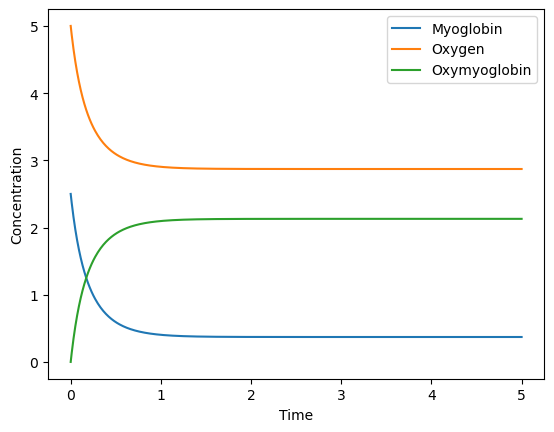

In [57]:
# Split up the solution matrix
t = solution.t
MbO2, Mb, O2 = solution.y

# Plot the solutions
plt.plot(t, Mb, label='Myoglobin')
plt.plot(t, O2, label='Oxygen')
plt.plot(t, MbO2, label='Oxymyoglobin')

# Prettify the figure
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()

# Display the figure
plt.show()

**Exercise 1e) Checking whether the system is in equilibrium**

From the law of mass action, we found an equilibrium condition for the system

$$\frac{[\mathrm{Mb}][\mathrm{O_2}]}{[\mathrm{MbO_2}]} = \frac{k_-}{k_+} = K_{\rm d}.$$

From the parameters you chose, do the following
* Compute $K_d$ from your chosen $k_-$ and $k_+$ values and print it out
* Find the values of the three concentrations at your final time point and compute their ratio
* Compare the two numbers, is the simulation at equilibrium at the final time point?

Hint: You can index sequences in Python from their end by using negative indices, so `t[-1]` would be the last element of the `t` array, `t[-2]` would be the second to last, and so on.

In [58]:
# Fill in code
Kd = km/kp
conc_ratio = Mb[-1]*O2[-1]/MbO2[-1]

print(f"Kd = {Kd:.2f}")
print(f"Concentration ratio at end of simulation is {conc_ratio:.2f}")

Kd = 0.50
Concentration ratio at end of simulation is 0.50


<a id='kinetics'></a>
## Exercise 2: Modeling Michaelis-Menten Kinetics

Let us model the Michaelis-Menten reaction and analyse the behavior

$${\rm S} + {\rm E} \underset{k_{-1}}{\overset{k_1}{\rightleftharpoons}} {\rm ES} \overset{k_2}{\rightarrow} {\rm E} + {\rm P}.$$

**Exercise 2a) Write out the ODEs**

(Use pen and paper).

Using the law of mass action, write out the system of ODEs that describe the four concentrations of the system

$$
\frac{\rm d[S]}{{\rm d}t} = k_{-1}[ES] - k_1[S][E], \qquad
\frac{\rm d[E]}{{\rm d}t} = (k_{-1} + k_2)[ES] - k_1[S][E], \qquad
\frac{\rm d[ES]}{{\rm d}t} = k_1[S][E] - (k_{-1} + k_2)[E][S], \qquad
\frac{\rm d[P]}{{\rm d}t} = k_2[ES]
$$

**Exercise 2b) Define the RHS function in Python**

Fill in the code below to define the RHS of the system

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [25]:
def rhs(t, y, k1p, k1m, k2):
    # Unpack the states
    S, E, ES, P = y
    
    # Compute derivatives
    dS_dt = k1m*ES - k1p*S*E
    dE_dt = (k1m + k2)*ES - k1p*S*E
    dES_dt = k1p*S*E - (k1m + k2)*ES 
    dP_dt = k2*ES
    
    # Return RHS as sequence
    return (dS_dt, dE_dt, dES_dt, dP_dt)

**Exercise 2c) Call `solve_ivp`**

Solve the system with the rates $k_{-1} = 1$, $k_1 = 2$, $k_2 = 3$. Let $[{\rm S}]_0 = 1$ and $[{\rm E}]_0 = 0.1$. Solve the system for $t\in[0, 30]$.

In [26]:
# Define time vector
time = (0,30)

# Define initial condition vector
y0 = (1, 0.1, 0, 0)

# Define parameter vector
k1p = 2
k1m = 1
k2 = 3
params = (k1p, k1m, k2)

# Call the ODE solver
solution = solve_ivp(rhs, time, y0, args=params, max_step=0.1)

**Exercise 2d) Plotting the solutions**

Now make two plots:
1. A plot of the substrate S and the product P
2. A plot of bound and free enzyme, SE and E: The ES state is only temporary- it is created temporarily, and slowly decays

Explain the time evolution of the different concentrations.

In [27]:
# Extract solution arrays
t = solution.t
S, E, ES, P = solution.y

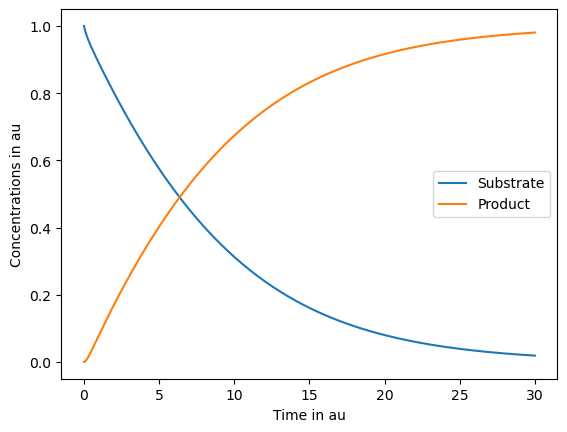

In [28]:
# Plot 1
plt.plot(t, S , label="Substrate")
plt.plot(t, P , label="Product")
plt.xlabel("Time in au") # au = arbritary units
plt.ylabel("Concentrations in au")
plt.legend()
plt.show()

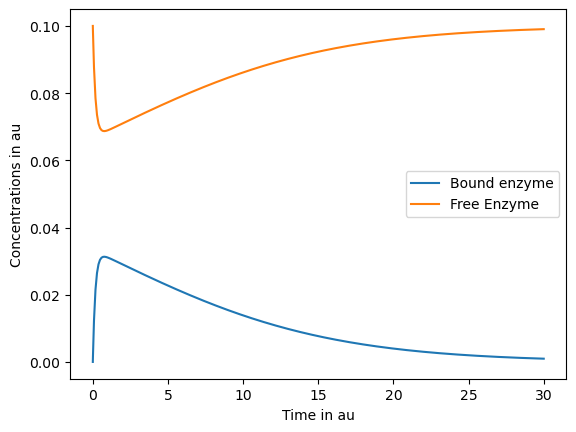

In [29]:
# Plot 2
plt.plot(t, ES , label="Bound enzyme")
plt.plot(t, E , label="Free Enzyme")
plt.xlabel("Time in au") # au = arbritary units
plt.ylabel("Concentrations in au")
plt.legend()
plt.show()

**Exercise 2e) Verify mass conservation**

As a verification, let us make sure our solution is mass conserving. The following two quantities should be constant throughout the simulation:
1. The total amount of enzyme $[\rm E] + [\rm ES]$
2. The sum of substrate and product: $[\rm S] + [\rm ES] + [\rm P]$

First discuss with your nearest neighbor *why* this should be the case. Then plot these curves and ensure that they are indeed constant. If they are not, go back and try to find your error.

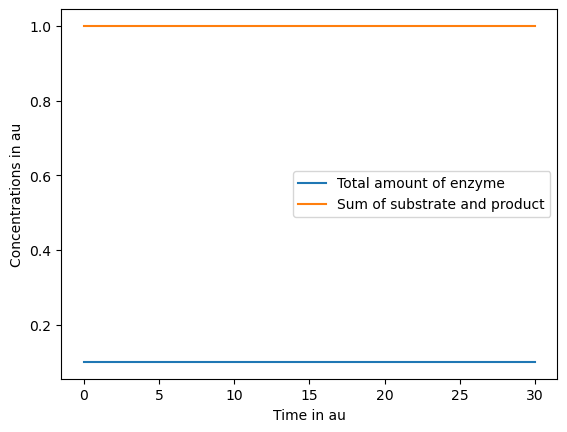

In [30]:
# Plot E + ES
plt.plot(t, E + ES,label = "Total amount of enzyme")

# Plot S + ES + P
plt.plot(t, S + ES + P, label = "Sum of substrate and product")

# Prettify the plot
plt.xlabel("Time in au") # au = arbritary units
plt.ylabel("Concentrations in au")
plt.legend()
plt.show()

**Exercise 2f) Comparing numerical results to the Michaelis-Menten equation**

The Michaelis-Menten gives the reaction velocity of the enzyme activity as

$$v = v_{\rm max} \frac{[S]}{K_m + [S]}, \qquad v_{\rm max} = k_2 [E]_{\rm tot}, \qquad K_m = \frac{k_{-1} + k_2}{k_1}.$$

In your code, you have not computed the reaction velocity itself, but recall that this is given by

$$[\dot{\rm P}] = k_2[{\rm ES}].$$

Plot the reaction velocity of your simulation and the reaction velocity predicted by the Michaelis-Menten equation in the same figure. Are the two different?

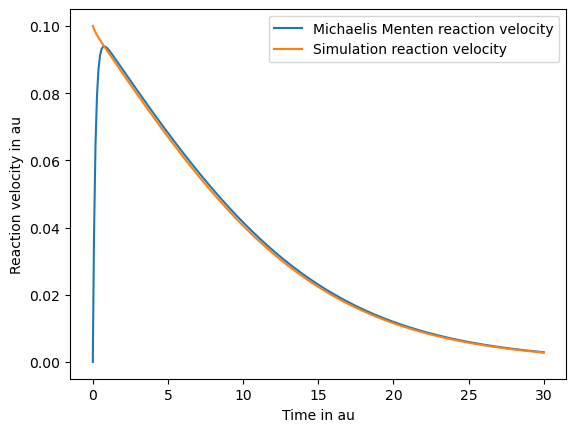

In [35]:
# Fill in your code here
dP_dt = k2 * ES
v_max = k2 * (E + ES)
Km = (k1m + k2)/k1p
v = v_max * S / (Km + S)
plt.plot(t, dP_dt, label = "Michaelis Menten reaction velocity")
plt.plot(t,v, label = "Simulation reaction velocity")
plt.xlabel("Time in au") # au = arbritary units
plt.ylabel("Reaction velocity in au")
plt.legend()
plt.show()

**Exercise 2g) Explaining the difference**

If you have programmed everything correctly, the two solutions should be slightly different. Explain why. 

**Hint:** What assumptions did we make when deriving the Michaelis-Menten equation?

**Solution:** The Michaelis-Menten method assumes quasi-static equilibrium, which is not applicable at the beginning of the simulation. However, with time, this equation is a good approximation for saving computational effort.